In [1]:
path = "./data/Benchmark/"
path_to_att_sbm = "./AttributedSBM/FitAttribute.R"
!rm -rf "./AttributedSBM"
!rm -rf "./CSBM"
!rm -rf "./data"

In [2]:
!pip install torch_geometric
!pip install rpy2
!git clone https://github.com/glmbraun/CSBM/
!git clone https://github.com/stanleyn/AttributedSBM.git
!pip install --upgrade --force-reinstall git+https://github.com/FelipeSchreiber/BregmanClustering.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 KB 15.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.0-py3-none-any.whl size=909897 sha256=432dd070d227baa7bbc310aac1a90abc5fc4989ec373e51a9c43cda3a78232e5
  Stored in directory: /root/.cache/pip/wheels/cd/7d/6b/17150450b80b4a3656a84330e22709ccd8dc0f8f4773ba4133
Successfully built torch_geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'CSBM'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 44 (delta 7), reused 33 (delta 3), pack-reused 0
Unpacking objects: 100% (44/44), 1.21 MiB | 7.74 MiB/s,

In [3]:
import fileinput
def modify_att_sbm(path):
    for i,line in enumerate(fileinput.input(path, inplace=True)):
        if i == 0: 
            print(f'{line.replace(")",",kmeansinit)")}', end='')
        elif i ==  27:
            print(f'#{line}', end='')
        else:
            print(line)

def modify_csbm(path):
    for i,line in enumerate(fileinput.input(path, inplace=True)):
        if "306" in line: 
            print(f'{line.replace("306","n")}')
        else:
            print(line)
modify_csbm("./CSBM/Python/functions.py")
modify_att_sbm(path_to_att_sbm)

In [4]:
import rpy2
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import importr
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
# Install packages
packnames = ("igraph", "reticulate","mvtnorm")
utils.install_packages(StrVector(packnames))

(as ‘lib’ is unspecified)







































	‘/tmp/Rtmpf69eIV/downloaded_packages’



<rpy2.rinterface_lib.sexp.NULLType object at 0x7f0f280752c0> [RTYPES.NILSXP]

In [5]:
%matplotlib inline
from BregmanClustering.WSBM import *
from copy import deepcopy
from sklearn.metrics import adjusted_rand_score, calinski_harabasz_score, normalized_mutual_info_score, accuracy_score
#from signet.cluster import Cluster
from sklearn.manifold import spectral_embedding,SpectralEmbedding
import scipy.sparse as ss
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import pairwise_kernels
import sys
from CSBM.Python.functions import *
import os
import warnings
from BregmanClustering import models
from BregmanClustering.models import SoftBregmanNodeAttributeGraphClustering as VEMbreg
from BregmanClusteringTorch.torch_models import SoftBregmanClusteringTorch as torchBreg
import rpy2.robjects as robjects
import subprocess
warnings.filterwarnings("ignore")

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 17 17:08:00 2023

@author: maximilien, Felipe Schreiber
"""
from tqdm import tqdm

SIZE_TITLE = 24
SIZE_LABELS = 24
SIZE_TICKS = 18
SIZE_LEGEND = 18

def unitRootCoordinates( d = 2, r=1 ):
    coordinates = []
    for k in range( d ):
        coordinates.append( [ r*np.cos(2*k*np.pi / d ), r*np.sin( 2*k*np.pi / d ) ])
    return coordinates

def generateData( sizes, p, mu ):
    n = sum( sizes )
    n_clusters = len( sizes )
    d = len( mu[0] )
    
    labels_true = [ ]
    for k in range( n_clusters ):
        labels_true += [ k for i in range( sizes[ k ] ) ]
    labels_true = np.asarray( labels_true, dtype = int )

    G = nx.stochastic_block_model( sizes, p )
    X = nx.adjacency_matrix( G ).todense()
    
    Y = np.zeros( ( n,d ) )
    for i in range( n ):
        Y[i,:] = np.random.normal( loc = mu[ labels_true[i] ] )
    return np.asarray(X), Y, labels_true


def plotting( x, curves, labels, xticks,
             curves_std = None,
             legendTitle = '', figTitle = '',
             xlabel = 'a', ylabel = 'ARI',
             saveFig = False, fileName = 'fig.eps'):
    
    if len( curves ) != len( labels ):
        raise TypeError( 'The number of labels is different from the number of curves' )
    
    if curves_std == None:
        for i in range( len( labels) ):
            plt.plot( x, curves[i], label = labels[i])
    else:
        for i in range( len( labels) ):
            plt.errorbar( x, curves[ i ], yerr = curves_std[ i ], linestyle = '-.', label = labels[ i ] )

    
    legend = plt.legend( title = legendTitle, loc=4,  fancybox=True, fontsize= SIZE_LEGEND )
    plt.setp( legend.get_title(),fontsize= SIZE_LEGEND )
    plt.xlabel( xlabel, fontsize = SIZE_LABELS )
    plt.ylabel( ylabel, fontsize = SIZE_LABELS )
    plt.xticks( xticks, fontsize = SIZE_TICKS )
    plt.yticks( fontsize = SIZE_TICKS )
    plt.title( figTitle, fontsize = SIZE_TITLE )
    if saveFig:
        plt.savefig( fileName, format = 'eps', bbox_inches = 'tight' )

#Somehow some errors message sometimes arises such as 
#RuntimeWarning: divide by zero encountered in log
#But this shouldn be a problem

In [7]:
c = 3
n = 100
N = c*n
delta = 10
d = 2
dim = c*d
P = np.array([[0.8, 0.2, 0.3],[0.2, 0.7, 0.4],[0.3, 0.4, 0.6]])
true_labels = [0]*n + [1]*n + [2]*n

In [8]:
X,Y = BregmanBenchmark(P,[n]*c,1,10,dims=2,weight_variance=0.01,att_variance=0.1,\
                       weight_distribution="logistic",attributes_distribution="logistic").generate_benchmark_WSBM()
A = (X != 0).astype(int)

In [9]:
X

array([[ 0.        ,  1.13730296,  0.9848446 , ...,  0.        ,
         4.6569574 ,  0.        ],
       [ 1.13730296,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.9848446 ,  0.        ,  0.        , ...,  4.65615681,
         0.        ,  4.5517695 ],
       ...,
       [ 0.        ,  0.        ,  4.65615681, ...,  0.        ,
         0.        ,  9.95049773],
       [ 4.6569574 ,  0.        ,  0.        , ...,  0.        ,
         0.        , 10.03755927],
       [ 0.        ,  0.        ,  4.5517695 , ...,  9.95049773,
        10.03755927,  0.        ]])

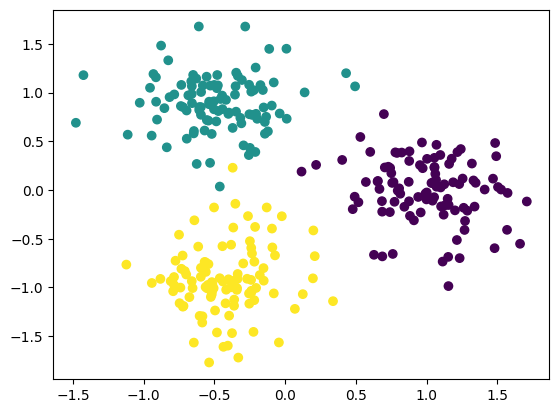

In [10]:
plt.scatter(Y[:,0],Y[:,1],c=true_labels)

In [11]:
def get_spectral_decomposition(A,k):
    if (A<0).any():
        A = pairwise_kernels(A,metric='rbf')
    U = SpectralEmbedding(n_components=k,affinity="precomputed").fit_transform(A)
    return U
def spectral(A,k):
    U = get_spectral_decomposition(A,k)
    return GaussianMixture(n_components=k).fit_predict(U.real)
pred_labels = spectral(X.copy(),c)
print(adjusted_rand_score(true_labels, pred_labels),normalized_mutual_info_score(true_labels, pred_labels))

1.0 1.0


In [12]:
pred_labels = GaussianMixture(n_components=c).fit_predict(Y.copy())
print(adjusted_rand_score(true_labels, pred_labels),normalized_mutual_info_score(true_labels, pred_labels))

0.9800666666666666 0.966016804452618


In [13]:
model = torchBreg(n_clusters=c,normalize_=True,thresholding=True)
model.fit(A, Y)
z_pred_both = model.predict(A,Y)
print(adjusted_rand_score(true_labels, z_pred_both),normalized_mutual_info_score(true_labels, z_pred_both))

Initialisation chosen from the graph
0
1.0 1.0


In [17]:
n_average = 10
n = 300
n_clusters = 2
d = 1
sizes = [ n // n_clusters ]*np.ones( n_clusters, dtype = int )

b = 5
pout = b * np.log( n ) / n

a_range = [ 5,7,9,11,13,15 ]
r_range = [ 0,1,2,3,4,5 ]
# a_range = [ 5,7,9]
# r_range = [ 0,1,2]

stats = {"varying":[],"a":[],"r":[],"agreed":[],"ARI_chernoff":[],"ARI_AIC":[],"ARI_ORACLE":[]}

for varying in ["attributes","graph"]:
# varying = 'attributes'
# #varying = 'graph'

    aris_attributes_mean = [ ]
    aris_graph_mean = [ ]
    aris_both_mean = [ ]
    aris_attSBM_mean = [ ]
    aris_IR_sLS_mean = [ ]
    aris_IR_LS_mean = [ ]
    aris_both2_mean = [ ]
    aris_oracle_mean = [ ]

    aris_attributes_std = [ ]
    aris_graph_std = [ ]
    aris_both_std = [ ]
    aris_attSBM_std = [ ]
    aris_IR_sLS_std = [ ]
    aris_IR_LS_std = [ ]
    aris_both2_std = [ ]
    aris_oracle_std = [ ]

    if varying == 'graph':
        loop = tqdm( range( len( a_range ) ) )
    else:
        loop = tqdm( range( len( r_range ) ) )

    for dummy in loop:
        if varying == 'graph':
            a = a_range[ dummy ]
            r = 1
        elif varying == 'attributes':
            a = 8
            r = r_range[ dummy ]
        mu = np.array([ [r], [-r] ])
        #print(mu.shape)
        #mu = unitRootCoordinates( d=2, r=r )

        pin = a * np.log( n ) / n
        p = (pin- pout) * np.eye( n_clusters ) + pout * np.ones( (n_clusters, n_clusters) )

        aris_attributes = [ ]
        aris_graph = [ ]
        aris_both = [ ]
        aris_attSBM = [ ]
        aris_IR_sLS  = [ ]
        aris_IR_LS = [ ]
        aris_both2 = [ ]
        aris_oracle = [ ]
        
        path_ = path+f"a/{a}/r/{r}/"
        if not os.path.exists(path_):
            os.makedirs(path_)

        total = 0
        for trial in range( n_average ):
            ( X, Y, z_true ) = generateData( sizes, p, mu )
            model = models.BregmanNodeAttributeGraphClustering( n_clusters = n_clusters, initializer="chernoff")
            ## For comparison purposes, the initialization is the same for IR-sLS, IR-LS and ours    
            model.initialize(X,Y)
            model.assignInitialLabels( X, Y )
            z_init = model.predicted_memberships
            chernoff_init_graph = model.graph_init
            chernoff_graph_labels = model.memberships_from_graph
            chernoff_att_labels = model.memberships_from_attributes

            with open(f'{path_}att_{trial}.npy', 'wb') as g:
                np.save(g, Y)
            with open(f'{path_}net_{trial}.npy', 'wb') as g:
                np.save(g, X)
            with open(f'{path_}z_init_{trial}.npy', 'wb') as g:
                np.save(g, convertZ(z_init)+1)

            model.fit( X, Y )
            z_pred_both = model.predict( X, Y )
            z_pred_graph = models.frommembershipMatriceToVector( chernoff_graph_labels )
            z_pred_attributes = models.frommembershipMatriceToVector( chernoff_att_labels )
            
            if chernoff_init_graph == model.AIC_initializer(X,Y).graph_init:
                total += 1
            
            ## Warm start
            if model.graph_init:
                model.fit( X, Y, chernoff_graph_labels)
            else:
                model.fit(X, Y, chernoff_att_labels)
            
            model2 = torchBreg(n_clusters=n_clusters, normalize_=True, thresholding=True)
            z_pred_both2 = model2.fit(X,Y).predict( X, Y )
            
            IR_sLS_pred = iter_csbm(X,Y,z_init,n_clusters)
            IR_LS_pred = iter_csbm2(X,Y,z_init,n_clusters)
                
            subprocess.call(["/usr/bin/Rscript","--vanilla","./run_AttSBM.r",\
                            f'{path_}att_{trial}.npy',\
                            f'{path_}net_{trial}.npy',\
                            f'{path_}z_init_{trial}.npy'])
            # r_code = f"""
            # source("run_AttSBM.r")
            # run_AttSBM({path_}att_{trial}.npy,{path_}net_{trial}.npy,{path_}z_init_{trial}.npy)"""
            # print(r_code)
            # robjects.r(r_code)

            attSBMPred = np.load("predict.npy")

            aris_attributes.append( adjusted_rand_score( z_true, z_pred_attributes ) )
            aris_graph.append( adjusted_rand_score( z_true, z_pred_graph ) )
            aris_both.append( adjusted_rand_score( z_true, z_pred_both ) )
            aris_attSBM.append( adjusted_rand_score( z_true, attSBMPred ) )
            aris_IR_sLS.append( adjusted_rand_score( z_true, IR_sLS_pred ) )
            aris_IR_LS.append( adjusted_rand_score( z_true, IR_LS_pred ) )
            aris_both2.append( adjusted_rand_score( z_true, z_pred_both2 ))
            
            if chernoff_init_graph != model.AIC_initializer(X,Y).graph_init:
                ## both initializations were done
                aris_oracle.append( max(aris_both[-1],aris_both2[-1]))
            elif chernoff_init_graph:
                z_pred_att_init = model.fit(X,Y,chernoff_att_labels).predict(X,Y)
                ari_att_init = adjusted_rand_score( z_true, z_pred_att_init)
                aris_oracle.append( max(aris_both[-1], ari_att_init))
            elif not chernoff_init_graph:
                z_pred_graph_init = model.fit(X,Y,chernoff_graph_labels).predict(X,Y)
                ari_graph_init = adjusted_rand_score( z_true, z_pred_graph_init)
                aris_oracle.append( max(aris_both[-1], ari_graph_init))
                
        aris_attributes_mean.append( np.mean( aris_attributes ) )
        aris_graph_mean.append( np.mean( aris_graph ) )
        aris_both_mean.append( np.mean( aris_both ) )
        aris_attSBM_mean.append( np.mean( aris_attSBM ) )
        aris_IR_sLS_mean.append( np.mean( aris_IR_sLS ) )
        aris_IR_LS_mean.append( np.mean( aris_IR_LS ) )
        aris_both2_mean.append( np.mean( aris_both2) )
        aris_oracle_mean.append( np.mean( aris_oracle) )
        
        aris_attributes_std.append( np.std( aris_attributes ) )
        aris_graph_std.append( np.std( aris_graph ) )
        aris_both_std.append( np.std( aris_both ) )
        aris_attSBM_std.append( np.std( aris_attSBM ) )
        aris_IR_sLS_std.append( np.std( aris_IR_sLS ) )
        aris_IR_LS_std.append( np.std( aris_IR_LS ) )
        aris_both2_std.append( np.std( aris_both2 ) )
        aris_oracle_std.append( np.std( aris_oracle) )
        
        stats["varying"].append(varying)
        stats["a"].append(a)
        stats["r"].append(r)
        stats["agreed"].append(total/n_average)
        stats["ARI_chernoff"].append(aris_both_mean[-1])
        stats["ARI_AIC"].append(aris_both2_mean[-1])
        stats["ARI_ORACLE"].append(aris_oracle_mean[-1])
        
    curves = [ aris_attributes_mean, aris_graph_mean,\
              aris_both_mean , aris_attSBM_mean, aris_IR_sLS_mean,\
              aris_IR_LS_mean, aris_both2_mean]

    curves_std = [ aris_attributes_std, aris_graph_std,\
                  aris_both_std , aris_attSBM_std, aris_IR_sLS_std,\
                  aris_IR_LS_std, aris_both2_std]

    labels = [ 'attributes', 'graph', 'both' , 'attSBM', 'IR_sLS', 'IR_LS', "VEMbreg"]
    saveFig = True
    if varying == 'graph':    
        fileName = 'N_' + str(n) + '_K_' + str(n_clusters) + '_b_' + str(b) + '_r_' + str(r) +  '_nAverage' + str(n_average) + '.eps'
        plotting( a_range, curves, labels, curves_std = curves_std, xticks = a_range, xlabel = 'a', saveFig = saveFig, fileName = fileName )
        plt.close()
    elif varying == 'attributes':
        fileName = 'N_' + str(n) + '_K_' + str(n_clusters) + '_a_' + str(a) + '_b_' + str(b) +  '_nAverage_' + str(n_average) + '.eps'
        plotting( r_range, curves, labels, curves_std = curves_std, xticks = r_range, xlabel = 'r', saveFig = saveFig, fileName = fileName )
        plt.close()

  0%|          | 0/6 [00:00<?, ?it/s]

Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
0
1
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
0
1
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
0
1
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chose

 17%|█▋        | 1/6 [01:33<07:46, 93.38s/it]

number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the graph
0
1
Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the graph
0
1
Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the graph
0
1
2
3
Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
0
1
Init

 33%|███▎      | 2/6 [03:09<06:20, 95.02s/it]

number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
0
1
2
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the graph
0
1
2
Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the graph
0
1
2
Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
number of iteratio

 50%|█████     | 3/6 [04:38<04:37, 92.38s/it]

Initialisation chosen from the attributes
Initialisation chosen from the attributes
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
0
1
2
3
4
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
0
1
2
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
0
1
2
3
4
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen 

 67%|██████▋   | 4/6 [06:20<03:12, 96.18s/it]

number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
0
1
2
3
4
5
6
7
8
9
10
11
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
0
1
2
3
4
5
6
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
0
1
2
3
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
Initialisa

 83%|████████▎ | 5/6 [08:11<01:41, 101.34s/it]

number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
0
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
0
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
0
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the attributes
number of 

100%|██████████| 6/6 [09:54<00:00, 99.14s/it] 

number of iterations :  25



  0%|          | 0/6 [00:00<?, ?it/s]

Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the graph
0
1
Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the attributes
0
1
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
0
1
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the g

 17%|█▋        | 1/6 [01:26<07:14, 86.84s/it]

Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
0
1
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
0
1
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the graph
0
1
Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25


 33%|███▎      | 2/6 [02:53<05:47, 86.87s/it]

Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the graph
0
1
2
Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
0
1
2
3
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
0
1
2
3
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterati

 50%|█████     | 3/6 [04:33<04:38, 92.78s/it]

number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
0
1
2
3
4
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
0
1
2
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
0
1
2
3
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of ite

 67%|██████▋   | 4/6 [06:30<03:24, 102.23s/it]

Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
0
1
2
3
4
5
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
0
1
2
3
4
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
0
1
2
3
4
5
6
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen f

 83%|████████▎ | 5/6 [08:16<01:43, 103.76s/it]

number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
0
1
2
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
0
1
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
0
1
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterations : 

100%|██████████| 6/6 [10:04<00:00, 100.76s/it]

number of iterations :  25


In [18]:
import pandas as pd
df = pd.DataFrame.from_dict(stats)

In [19]:
df

,varying,a,r,agreed,ARI_chernoff,ARI_AIC,ARI_ORACLE
0,attributes,8,0,0.5,0.273093,0.000000,0.273093
1,attributes,8,1,0.6,0.794563,0.000000,0.798027
2,attributes,8,2,0.1,0.982729,0.000000,0.982729
3,attributes,8,3,0.8,0.997333,0.000000,0.997333
4,attributes,8,4,1.0,1.000000,0.281574,1.000000
5,attributes,8,5,0.9,1.000000,1.000000,1.000000
6,graph,5,1,0.4,0.131004,0.000000,0.276638
7,graph,7,1,0.4,0.576786,0.000000,0.640891
8,graph,9,1,0.9,0.915214,0.000000,0.920423
9,graph,11,1,0.9,0.997333,0.000000,0.997333
